In [1]:
import config
from cnn_builder import *
from dataset_functions import *
import gc
from hypercube_set import HypercubeSet
from hypercube_loader import *
import papers.aspn
import glob
import keras
import numpy as np
import os
import paths
import pickle
from rendering import *
import sys

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

%load_ext autoreload
%autoreload 2

inf = 2e32

## Dataset

In [2]:
sampling_strategy = 'not minority'

In [ ]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=True, n_max_cubes=inf))
hc_set.print_metadata()

#### Dataset creation
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=test_split, patch_size=config.patch_size, patch_overlapping=config.patch_overlapping)

#### Preprocessing
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

In [3]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

In [ ]:
# Look for a file with the network name under the history folder
history_file = os.path.join(paths.result_folder + 'history/', network_name + "*.p")
history_files = glob.glob(history_file)

for history_file in history_files:
    # Load history with pickle
    history = pickle.load(open(history_file, "rb"))
    render_model_history(history, model_name=network_name)

In [ ]:
# Read network weights
network_weights_file = os.path.join(paths.result_folder + 'network/', network_name + "*.h5")
network_weights_files = glob.glob(network_weights_file)
if len(network_weights_files) > 0:
    network_weights_file = network_weights_files[-1]
    print("Loading weights file " + network_weights_file)
    model = keras.models.load_model(network_weights_file,
                                    custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                    'SecondOrderPooling': papers.aspn.SecondOrderPooling})

    model.summary()

In [ ]:
num_classes = hc_set.get_num_classes()
if paths.target_area == 2:
    num_classes -= 3

In [ ]:
### Split test
X_test, y_test = hc_set.split_test(patch_size=config.patch_size)
y_test = reduce_labels_center(y_test)
X_test, y_test = remove_labels(X_test, y_test, [num_classes, num_classes + 1, num_classes + 2])
(X_test, y_test), _, _ = balance_classes(X_test, y_test, reduce=True, clustering=False,
                                         strategy=sampling_strategy)

In [ ]:
    test_prediction_prob = model.predict(X_test)
    test_prediction = np.argmax(test_prediction_prob, axis=1)
    metrics.append_evaluation(y_test, test_prediction, test_prediction_prob)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

## Window Size Tests

### OA

In [ ]:
# Read network metrices with network_type root name (e.g. allopezr_2d)
network_metrics_file = os.path.join(paths.result_folder + 'metrics/', network_type + "*_window_size_test.p")
network_metrics_files = glob.glob(network_metrics_file)

In [ ]:
oa_window_size = []

for network_metrics_file in network_metrics_files:
    # Load history with pickle
    network_metrics = pickle.load(open(network_metrics_file, "rb"))
    # Extract patch size from file name
    file_name_strings = network_metrics_file.split("_")
    for string in file_name_strings:
        if 'x' in string:
            patch_size = int(string.split("x")[0])
            break

    oa_window_size.append((patch_size, network_metrics.get_oa()))

# Sort by patch size
oa_window_size.sort(key=lambda tup: tup[0])
render_window_size_metric(oa_window_size, annotate_indices=[4, 6, 8, 10], title="a) Red varieties")

### Training time + capacity

In [ ]:
# Read history files
# Read network metrices with network_type root name (e.g. allopezr_2d)
network_history_file = os.path.join(paths.result_folder + 'red/' + 'history/', network_type + "*_window_size_test.p")
network_history_files = glob.glob(network_history_file)

network_file = os.path.join(paths.result_folder + 'red/' + 'network/', network_type + "*_window_size_test_0.h5")
network_files = glob.glob(network_file)

In [ ]:
training_time = []
capacity = []

for (history_file, network_file) in zip(network_history_files, network_files):
    # Load history with pickle
    network_history = pickle.load(open(history_file, "rb"))
    # Extract patch size from file name
    file_name_strings = network_file.split("_")
    for string in file_name_strings:
        if 'x' in string:
            patch_size = int(string.split("x")[0])
            break

    model = keras.models.load_model(network_file,
                                custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                'SecondOrderPooling': papers.aspn.SecondOrderPooling})
    model.num_params = model.count_params()

    training_time.append((patch_size, network_history.get_training_time()))
    capacity.append((patch_size, model.num_params))

    del model
    gc.collect()

# Sort by patch size
training_time.sort(key=lambda tup: tup[0])
capacity.sort(key=lambda tup: tup[0])

In [ ]:
render_time_capacity(training_time, capacity, title="a) Red varieties")

## Ablation study

In [ ]:
ablation_suffix = ["no_input_convs", "naive_exception", "advanced_exception", "no_attention"]

# Search files with ablation suffixes in metrics folder
ablation_metrics_files = []
for suffix in ablation_suffix:
    ablation_metrics_file = os.path.join(paths.result_folder + 'metrics/', network_type + "*_" + suffix + ".p")
    ablation_metrics_files.append(glob.glob(ablation_metrics_file))

for (ablation_label, metric_file) in zip(ablation_suffix, ablation_metrics_files):
    # Load history with pickle
    print('------------- ' + ablation_label + ' -------------')
    network_metrics = pickle.load(open(metric_file[0], "rb"))
    print(network_metrics.print_metrics())

# History time and num parameters

In [ ]:
from keras.layers import Lambda
import papers.spectral_net

network_types = [ 'allopezr_2d', 'lt_cnn', 'nezami', 'jigsaw_hsi', 'spectral_net', 'hybrid_sn', 'aspn']
network_label = ['Ours', 'Lt-CNN', 'Nezami et al.', 'Jigsaw HSI', 'SpectralNet', 'HybridSN', 'ASPN']
num_params_typeset = [0, 0, 0, 0, 7826889, 0, 8229]
training_time = []
num_params = []

for network_type in network_types:
    print(network_type)
    read_json_config(paths.config_file, network_type=network_type)
    network_name = get_name(network_type)

    # read history pickle file
    history_files = glob.glob(os.path.join(paths.result_folder + 'history/', network_name + "_0.p"))
    for history_file in history_files:
        history = pickle.load(open(history_file, "rb"))
        training_time.append(history.get_training_time())

    # read network pickle file
    network_files = glob.glob(os.path.join(paths.result_folder + 'network/', network_name + "*.h5"))
    for network_file in network_files:
        try:
            model = keras.models.load_model(network_file,
                                        custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                        'SecondOrderPooling': papers.aspn.SecondOrderPooling})
            model.num_params = model.count_params()
            num_params.append(model.num_params)

            del model
            gc.collect()
            break
        except:
            print("Error loading model")
            num_params.append(num_params_typeset[network_types.index(network_type)])
            break

In [ ]:
print(training_time)
print(num_params)

In [ ]:
render_network_training(network_label, training_time, num_params)

# Spatial labelling

In [3]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

In [7]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=2e32))
hc_set.print_metadata()
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)
num_classes = hc_set.get_num_classes()
hc_set.swap_classes(0, num_classes - 1)
reduction, scaler = hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
Min: 0.006675803568214178, Max: 0.14739923179149628, Size: (1872, 640, 223)
on 0: (109049, 223)                                                                                                     
|████████████████████████████████████████| 2/2 [100%] in 12.0s (0.11/s)                                                 


In [22]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=2e32))
hc_set.print_metadata()
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)
num_classes = hc_set.get_num_classes()
hc_set.swap_classes(0, num_classes - 1)
hc_set.standardize(num_features=config.num_target_features,selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
Reading media/Mateus_2022/red\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)
on 0: (323312, 223)                                                                                                     
|⚠︎                                       | (!) 0/2 [0%] in 3.5s (0.00/s)                                                


AttributeError: 'NoneType' object has no attribute 'fit'

In [8]:
# Load network
network_file = os.path.join(paths.result_folder + 'network/', network_name + "_0.h5")
model = keras.models.load_model(network_file,
                            custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                            'SecondOrderPooling': papers.aspn.SecondOrderPooling})

Processing hypercube 0
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.4s (302795.69/s)                                   
X_train_swath shape: (89614, 23, 23, 30)
2801/2801 [==============================] - 12s 4ms/step
Processed 100000 pixels
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.4s (218971.22/s)                                   
X_train_swath shape: (96412, 23, 23, 30)
3013/3013 [==============================] - 13s 4ms/step
Processed 200000 pixels
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.5s (193540.16/s)                                   
X_train_swath shape: (96412, 23, 23, 30)
3013/3013 [==============================] - 13s 4ms/step
Processed 300000 pixels
Available indices: (100000,)
|████████████████████████████████████████| 100000/100000 [100%] in 0.4s (265345.26/s)                                   
X_train_

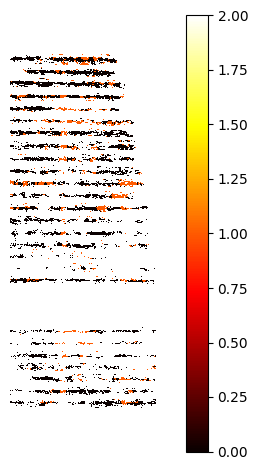

In [9]:
batch_size = 100000
num_hypercubes = hc_set.get_num_hypercubes()

for i in range(0, num_hypercubes):
    print("Processing hypercube " + str(i))

    predicted_swath = None
    y_swath = None
    num_processed_pixels = 0

    while True:
        X_train_swath, y_train_swath = hc_set.split_swath(patch_size=config.patch_size, patch_id=i, limit=batch_size, offset=num_processed_pixels)
        if X_train_swath is not None:
            print("X_train_swath shape: " + str(X_train_swath.shape))
        if X_train_swath is None:
            break
        if X_train_swath.shape[0] == 0:
            break

        y_train_swath = reduce_labels_center(y_train_swath)
        predicted_labels = model.predict(X_train_swath)
        predicted_labels = np.argmax(predicted_labels, axis=1)

        if predicted_swath is None:
            predicted_swath = predicted_labels
            y_swath = y_train_swath
        else:
            predicted_swath = np.append(predicted_swath, predicted_labels)
            y_swath = np.append(y_swath, y_train_swath)

        num_processed_pixels += batch_size
        del X_train_swath, y_train_swath, predicted_labels
        gc.collect()

        print("Processed " + str(num_processed_pixels) + " pixels")

    label_diff = hc_set.compose_swath_evaluation(y_swath, predicted_swath, patch_size=config.patch_size)
    rendering.render_label_diff(label_diff=label_diff, filename='swaths/' + paths.target_area + '_2021_' + str(i) + '.png')

    del predicted_swath, y_swath
    gc.collect()

## Class separability

In [ ]:
# Load network
network_file = os.path.join(paths.result_folder + 'network/', network_name + "_0.h5")
model = keras.models.load_model(network_file,
                            custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                            'SecondOrderPooling': papers.aspn.SecondOrderPooling})

In [5]:
hc_set = HypercubeSet(hc_array=load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=2e32))
hc_set.print_metadata()
hc_set.obtain_ground_labels()
hc_set.obtain_train_indices(test_percentage=config.test_split, patch_size=config.patch_size,
                            patch_overlapping=config.patch_overlapping)
num_classes = hc_set.get_num_classes()
hc_set.swap_classes(0, num_classes - 1)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
Reading media/Mateus_2022/red\raw_7584_rf.hdr ...
Min: 0.006377667188644409, Max: 0.16416394710540771, Size: (1840, 3200, 223)
on 0: (274495, 223)                                                                                                     
|████████████████████████████████████████| 2/2 [100%] in 39.0s (0.03/s)                                                 


(FactorAnalysis(n_components=30, random_state=42), StandardScaler())

In [18]:
X_train, y_train = hc_set.split_train(patch_size=config.patch_size, max_train_samples=60000, starting_index=0, remove=False)
num_classes = hc_set.get_num_classes()
y_train = reduce_labels_center(y_train)
X_train, y_train = remove_labels(X_train, y_train, [num_classes])
(X_train, y_train), _, _ = balance_classes(X_train, y_train, reduce=True, clustering=False, strategy=sampling_strategy)

|████████████████████████████████████████| 60000/60000 [100%] in 0.3s (225785.50/s)                                     


In [19]:
predict_model = keras.Model(model.input, model.layers[-2].output)
predict_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 23, 30)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape (Reshape)              (None, 529, 30)      0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 529, 30)      0           ['reshape[0][0]']                
                                                                                                  
 spatial_attention (SpatialAtte  (None, 529, 30)     1058        ['lambda[0][0]']           

In [20]:
predicted_train = predict_model.predict(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3]))

637/637 [==============================] - 3s 4ms/step


In [21]:
embedding = embed_manifold(predicted_train, True, num_components=2)

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



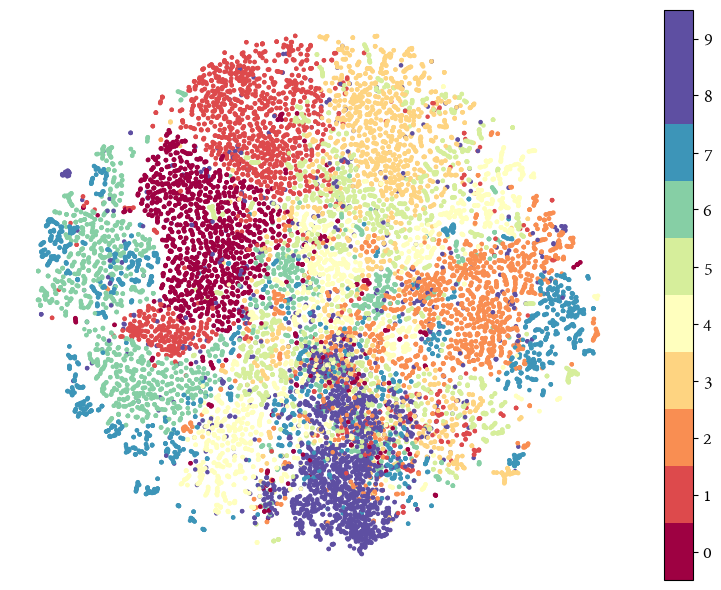

In [22]:
render_manifold_separability(embedding, y_train, include_annotations=False)

### 3D

In [44]:
embedding = embed_manifold(predicted_train, True, num_components=3)
render_3d_manifold_separability(embedding, y_train)

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



SystemExit: 0

C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\IPython\core\interactiveshell.py:3441: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.

